# Test multi-target Mapper

In [ ]:
from pixasonics.core import App, Mapper
from pixasonics.features import MeanChannelValue
from pixasonics.synths import Theremin, FilteredNoise, SimpleFM
from IPython.display import display, Audio

## Multi-target, single channel

In [ ]:
app0 = App()
app0.load_image_file("images/test.jpg")
mean_red = MeanChannelValue(filter_channels=0, name="MeanRed")
app0.attach(mean_red)
theremin0 = Theremin()
app0.attach(theremin0)
filtered_noise0 = FilteredNoise()
app0.attach(filtered_noise0)
red2freqs = Mapper(mean_red, [theremin0["frequency"], filtered_noise0["cutoff"]], name="Red2Freqs")
app0.attach(red2freqs)

In [ ]:
red2freqs.in_low, red2freqs.in_high, red2freqs.out_low, red2freqs.out_high, red2freqs.exponent

In [ ]:
# test NRT
duration = 5
my_timeline = [
    (0, {
        "probe_width": 50,
        "probe_height": 50,
        "probe_x": 0,
        "probe_y": 0
    }),
    (duration, {
        "probe_x": 499,
        "probe_y": 499,
    })
]

target_filename = "multitarget_nrt_test.wav"

app0.render_timeline_to_file(my_timeline, target_filename)

display(Audio(target_filename))

## Multi-target, multi-channel

In [ ]:
app1 = App()
app1.load_image_file("images/test.jpg")
mean_pix = MeanChannelValue()
app1.attach(mean_pix)
num_channels = 3
theremin1 = Theremin([440 for _ in range(num_channels)])
app1.attach(theremin1)
filtered_noise1 = FilteredNoise(cutoff=[440 for _ in range(num_channels)])
app1.attach(filtered_noise1)
red2freqs1 = Mapper(mean_pix, [theremin1["frequency"], filtered_noise1["cutoff"]], name="Red2Freqs1")
app1.attach(red2freqs1)

In [ ]:
# test NRT
duration = 5
my_timeline = [
    (0, {
        "probe_width": 50,
        "probe_height": 50,
        "probe_x": 0,
        "probe_y": 0
    }),
    (duration, {
        "probe_x": 499,
        "probe_y": 499,
    })
]

target_filename = "multitarget_nrt_test.wav"

app1.render_timeline_to_file(my_timeline, target_filename)

display(Audio(target_filename))

# Test custom Feature + custom Mapper

In [ ]:
from pixasonics.core import App, Mapper
from pixasonics.features import MeanChannelValue, Feature
from pixasonics.synths import Theremin, FilteredNoise, SimpleFM
from IPython.display import display, Audio
import numpy as np
import os
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KDTree
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

In [2]:
app = App()

Box(children=(Box(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='…

[miniaudio] Output device: MacBook Pro Speakers (48000Hz, buffer size 480 samples, 2 channels)


In [3]:
app.load_image_file("images/cellular_dataset/merged_8bit/Timepoint_001_220518-ST_C03_s1.jpg")

In [ ]:
# combine red and green channels and all layers
img_folder = "images/cellular_dataset/single_channel_16bit/"
img_files = os.listdir(img_folder)
imgs_red = [f for f in img_files if f.endswith("w2.TIF")] # only red channel images
imgs_green = [f for f in img_files if f.endswith("w1.TIF")] # only green channel images
imgs = []
for img_red, img_green in zip(imgs_red, imgs_green):
    img_path_red = os.path.join(img_folder, img_red)
    img_path_green = os.path.join(img_folder, img_green)
    img_red = Image.open(img_path_red)
    img_green = Image.open(img_path_green)
    img_red = np.array(img_red)
    img_green = np.array(img_green)
    img = np.stack([img_red, img_green], axis=-1) # now the last dimension is the channel dimension
    imgs.append(img)
img = np.stack(imgs, axis=-1) # now the last dimension is the layer dimension
print(img.shape)
app.load_image_data(img) # load as numpy array

In [33]:
# synthmaps_pca_mel_json = "/Volumes/T7RITMO/synthmaps_code/data/pca_mels_mean.json"
synthmaps_pca_mel_json = "/Volumes/T7RITMO/synthmaps_code/data/pca_perceptual.json"
# synthmaps_pca_mel_json = "/Volumes/T7RITMO/synthmaps_code/data/pca_encodec.json"
# synthmaps_pca_mel_json = "/Volumes/T7RITMO/synthmaps_code/data/pca_clap.json"
with open(synthmaps_pca_mel_json, "r") as f:
    pca_mel_data = json.load(f)
print(pca_mel_data.keys())

dict_keys(['cols', 'data'])


In [5]:
def fluid_dataset2array(
        dataset: dict,
) -> np.ndarray:
    """
    Convert a json dataset to a numpy array.

    Args:
        dataset (dict): The json dataset to convert.

    Returns:
        np.ndarray: The numpy array.
    """
    num_cols = dataset["cols"]
    num_rows = len(dataset["data"])
    out_array = np.zeros((num_rows, num_cols))
    for i in range(num_rows):
        out_array[i] = np.array(dataset["data"][str(i)])
    return out_array

In [34]:
pca_mel_data_array = fluid_dataset2array(pca_mel_data)
print(pca_mel_data_array.shape)

(132651, 2)


In [35]:
synthmaps_scaler = MinMaxScaler()
pca_mel_data_scaled = synthmaps_scaler.fit_transform(pca_mel_data_array)
print(pca_mel_data_scaled.shape)
print(pca_mel_data_scaled.min(), pca_mel_data_scaled.max())

(132651, 2)
0.0 1.0


In [8]:
fm_params_json = "/Volumes/T7RITMO/synthmaps_code/data/fm_params.json"
with open(fm_params_json, "r") as f:
    fm_params_data = json.load(f)
print(fm_params_data.keys())
fm_params_data_array = fluid_dataset2array(fm_params_data)
print(fm_params_data_array.shape)

dict_keys(['cols', 'data'])
(132651, 3)


In [36]:
class PCA2D(Feature):
    def __init__(self, name="PCA2D"):
        super().__init__(name=name)
        self.pca = None
        self.pca_scaler = None
        self._original_shape = None
        self._transformed_points = None

    def _reshape_for_pca(self, mat):
        """Helper to reshape 4D matrix (H, W, Ch, L) to 2D by concatenating the Channel and Layer dimensions"""
        mat_reshaped = mat.reshape(mat.shape[0], mat.shape[1], -1)
        return mat_reshaped.reshape(-1, mat_reshaped.shape[-1])

    def process_image(self, mat):
        self._original_shape = mat.shape
        features = self._reshape_for_pca(mat)
        self.pca = IncrementalPCA(n_components=2)
        self.pca.fit(features)
        self.pca_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
        self._transformed_points = self.pca.transform(features)
        self.pca_scaler.fit(self._transformed_points)
        projected_scaled = self.pca_scaler.transform(self._transformed_points)
        return projected_scaled.T
    
    def compute(self, mat):
        if self.pca is None:
            raise ValueError("PCA model has not been fitted. Call process_image first.")
        features = self._reshape_for_pca(mat)
        projected = self.pca.transform(features)
        projected_scaled = self.pca_scaler.transform(projected)
        projected_scaled_mean = projected_scaled.mean(axis=0, keepdims=False)
        return projected_scaled_mean


pca_2d = PCA2D()
app.attach(pca_2d)

(250000, 2)


Text(0, 0.5, 'PCA 2')

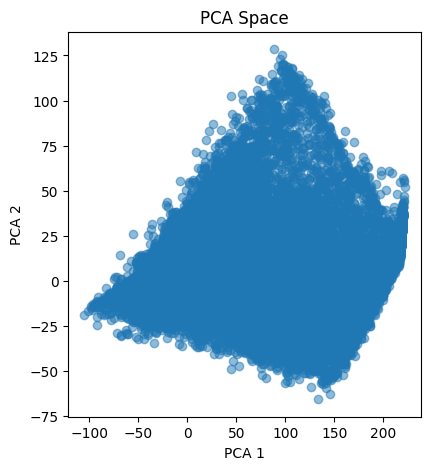

In [28]:
#plot the pca space
plt.figure(figsize=(10, 5))

plt.subplot(121)

points = pca_2d._transformed_points
print(points.shape)
plt.scatter(points[:, 0], points[:, 1], alpha=0.5)
plt.title('PCA Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [14]:
fm = SimpleFM()
app.attach(fm)

In [37]:
class PCA2FMParams(Mapper):
    def __init__(self, source, target_fm, name="PCA2FMParams"):
        super().__init__(source, [target_fm["carrier_freq"], target_fm["harm_ratio"], target_fm["mod_index"]], name=name)
        self.kdtree = KDTree(pca_mel_data_scaled)

    def map(self, in_data):
        nearest_idx = self.kdtree.query(in_data.T, return_distance=False)[0][0]
        fm_params = fm_params_data_array[nearest_idx]
        return fm_params

pca2fm_params = PCA2FMParams(pca_2d, fm)
app.attach(pca2fm_params)